# Encoder And Decoder Model

![](https://github.com/tensorflow/nmt/blob/master/nmt/g3doc/img/attention_equation_0.jpg)

# 0 . GPU测试

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# gpu_device_name = tf.test.gpu_device_name()
# print(gpu_device_name)

## 显存限制  --以下有三种配置显存的方法

默认情况下，TensorFlow会映射该进程可见的所有GPU的几乎所有GPU内存（取决于CUDA_VISIBLE_DEVICES）。 这样做是为了通过减少内存碎片来更有效地使用设备上相对宝贵的GPU内存资源。 要将TensorFlow限制为一组特定的GPU，我们使用tf.config.experimental.set_visible_devices方法。

In [3]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
#     try:
#         tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
#     except RuntimeError as e:
#         # Visible devices must be set before GPUs have been initialized
#         print(e)

在某些情况下，希望该过程仅分配可用内存的子集，或者仅增加该过程所需的内存使用量。 TensorFlow提供了两种控制方法。

第一种选择是通过调用tf.config.experimental.set_memory_growth来打开内存增长，tf.config.experimental.set_memory_growth尝试仅分配运行时分配所需的GPU内存：它开始分配的内存很少，并且随着程序的运行和 需要更多的GPU内存，我们扩展了分配给TensorFlow进程的GPU内存区域。 请注意，我们不会释放内存，因为它可能导致内存碎片。 要打开特定GPU的内存增长，请在分配任何张量或执行任何操作之前使用以下代码。

In [4]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#     # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#             logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#             print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Memory growth must be set before GPUs have been initialized
#         print(e)

启用此选项的另一种方法是将环境变量TF_FORCE_GPU_ALLOW_GROWTH设置为true。 此配置是特定于平台的。

第二种方法是使用tf.config.experimental.set_virtual_device_configuration配置虚拟GPU设备，并对要在GPU上分配的总内存设置硬限制。

In [5]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
        # 通过这里的memory_limit来进行设置
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


如果您想真正绑定TensorFlow进程可用的GPU内存量，这将很有用。 当GPU与其他应用程序（例如工作站GUI）共享GPU时，这是本地开发的常见做法。`

今天我们来做NLP（自然语言处理）中Sequence2Sequence的任务。其中Sequence2Sequence任务在生活中最常见的应用场景就是机器翻译。除了机器翻译之外，现在很流行的对话机器人任务，摘要生成任务都是典型的Sequence2Sequence。Sequence2Sequence的难点在于模型需要干两件比较难的事情：

+ 语义理解（NLU:Natural Language Understanding）：模型必须理解输入的句子。
+ 句子生成(NLG:Natural Language Generation)：模型生成的句子需符合句法，不能是人类觉得不通顺的句子。

想想看，让模型理解输入句子的语义已经很困难了，还得需要它返回一个符合人类造句句法的序列。不过还是那句话，没有什么是深度学习不能解决的，如果有，当我没说上句话。

1. basic encoder-decoder ：将encode出来的编码全部丢给decode每个step
![](https://upload-images.jianshu.io/upload_images/9168245-6e5404af1d88efa6.jpg?imageMogr2/auto-orient/strip|imageView2/2/w/509/format/webp)

2. encoder-decoder with feedback ：将encode出来的编码只喂给decode的初始step，在解码器端，需将每个step的输出，输入给下一个step。
![](https://upload-images.jianshu.io/upload_images/9168245-e80ad756cad700df.jpg?imageMogr2/auto-orient/strip|imageView2/2/w/514/format/webp)


3. encoder-decoder with peek：1和2的组合，不仅将encode出来的编码全部丢给decode每个step，在解码器端，也将每个step的输出，输入给下一个step。
![](https://upload-images.jianshu.io/upload_images/9168245-fd3175be92533464.jpg?imageMogr2/auto-orient/strip|imageView2/2/w/544/format/webp)

4.encoder-decoder with attention:将3模型的encode端做了一个小小的改进，加入了attention机制，简单来说，就是对encode端每个step的输入做了一个重要性打分。

![](https://upload-images.jianshu.io/upload_images/9168245-e3773b933a5c359c.jpg?imageMogr2/auto-orient/strip|imageView2/2/w/519/format/webp)

本次实验采用的是basic encoder-decoder架构，下面开始实战部分。

对对联实战
数据加载
数据样式如下图所示是一对对联。模型的输入时一句"晚 风 摇 树 树 还 挺"，需要模型生成" 晨 露 润 花 花 更 红"。这个数据集有个特点，就是输入输出是等长的，序列标注算法在这个数据集上也是适用的。

In [6]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [8]:
%load_ext autoreload
%autoreload 2
import warnings
# warnings.filterwarnings("ignore")
import sys
# 要导入代码的路径 ,utils无法导入的同学,添加上自己code的路径 ,项目代码结构 code/utils ....
sys.path.append('D:/Learning/Project/QA/version1/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import pandas as pd
import numpy as np
from utils.data_loader import build_dataset,load_dataset
from utils.wv_loader import load_embedding_matrix,load_vocab
from utils.config import *
from gensim.models.word2vec import LineSentence, Word2Vec
import tensorflow as tf
from model_layers import seq2seq_model
import time

Building prefix dict from the default dictionary ...
2020-05-19 14:43:27,720 : DEBUG : Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\17854\AppData\Local\Temp\jieba.cache
2020-05-19 14:43:27,721 : DEBUG : Loading model from cache C:\Users\17854\AppData\Local\Temp\jieba.cache
Loading model cost 0.615 seconds.
2020-05-19 14:43:28,336 : DEBUG : Loading model cost 0.615 seconds.
Prefix dict has been built successfully.
2020-05-19 14:43:28,337 : DEBUG : Prefix dict has been built successfully.


# 0. 预处理数据

In [1]:
# build_dataset(train_data_path,test_data_path)

# 1. 加载数据

## 1.1 加载数据集

In [17]:
root='D:/Learning/Project/QA/version1/data/couplet'

In [18]:
with open (root+"/train/in.txt","r", encoding='utf-8') as f:
    data_in = f.read()
with open (root+"/train/out.txt","r", encoding='utf-8') as f:
    data_out = f.read()
    
train_X = data_in.split("\n")
train_Y = data_out.split("\n")

train_X = [data.split() for data in train_X]
train_Y = [data.split() for data in train_Y]

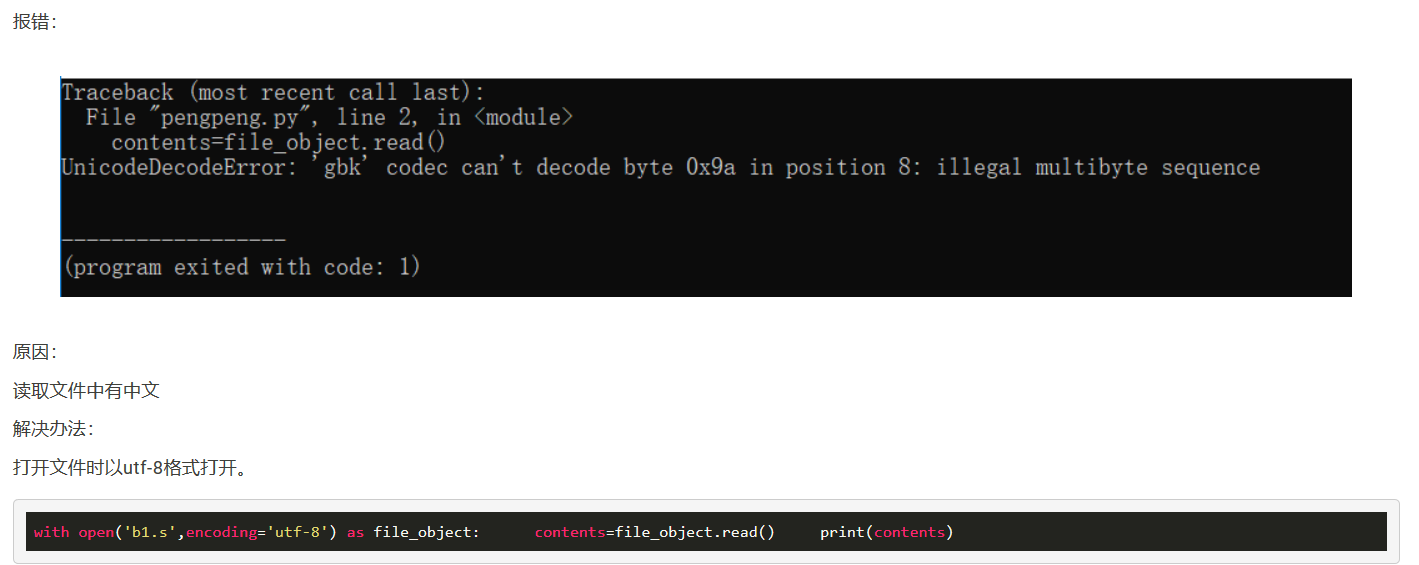

In [19]:
train_Y[1:3]

[['万', '方', '乐', '奏', '有', '于', '阗'], ['绿', '柳', '堤', '新', '燕', '复', '来']]

执行上方代码将数据变成list，其格式如下：
data_in_list[1:3] :

[['愿', '景', '天', '成', '无', '墨', '迹'], ['丹', '枫', '江', '冷', '人', '初', '去']]

data_out_list[1:3]:

[['万', '方', '乐', '奏', '有', '于', '阗'], ['绿', '柳', '堤', '新', '燕', '复', '来']]


# 构造字典

In [20]:
import itertools
# 获取所有的字
words = list(itertools.chain.from_iterable(train_X))+list(itertools.chain.from_iterable(train_Y))
# 去重
words = set(words)
# 构建vocab
vocab = {word: index+1 for index ,word in enumerate(words)}
# 添加unk标签
vocab["unk"] = 0

In [33]:
vocab

{'悊': 1,
 '樾': 2,
 '孙': 3,
 '筇': 4,
 '雨': 5,
 '年': 6,
 '玄': 7,
 '局': 8,
 '淮': 9,
 '鞠': 10,
 '阽': 11,
 '遙': 12,
 '悻': 13,
 '埤': 14,
 '畦': 15,
 '糍': 16,
 '哥': 17,
 '趼': 18,
 '睏': 19,
 '蛸': 20,
 '硗': 21,
 '電': 22,
 '镴': 23,
 '旬': 24,
 '溇': 25,
 '哒': 26,
 '倒': 27,
 '见': 28,
 '陇': 29,
 '舷': 30,
 '岊': 31,
 '漫': 32,
 '饤': 33,
 '聚': 34,
 '禢': 35,
 '硏': 36,
 '刨': 37,
 '鸶': 38,
 '淏': 39,
 '鄂': 40,
 '殆': 41,
 '怂': 42,
 '答': 43,
 '蓥': 44,
 '棔': 45,
 '呼': 46,
 '甴': 47,
 '痉': 48,
 '秊': 49,
 '德': 50,
 '戴': 51,
 '趾': 52,
 '麑': 53,
 '笣': 54,
 '碟': 55,
 '痌': 56,
 '缥': 57,
 '戚': 58,
 '宣': 59,
 '甫': 60,
 '单': 61,
 '禨': 62,
 '侑': 63,
 '锛': 64,
 '蛹': 65,
 '、': 66,
 '铮': 67,
 '哆': 68,
 '糗': 69,
 '蜍': 70,
 '商': 71,
 '笊': 72,
 '燋': 73,
 '盲': 74,
 '虱': 75,
 '漈': 76,
 '腠': 77,
 '僊': 78,
 '燦': 79,
 '挐': 80,
 '敷': 81,
 '斸': 82,
 '驹': 83,
 '蟀': 84,
 '畛': 85,
 '意': 86,
 '份': 87,
 '喾': 88,
 '樏': 89,
 '耘': 90,
 '踬': 91,
 '箩': 92,
 '缂': 93,
 '咥': 94,
 '焦': 95,
 '灈': 96,
 '惯': 97,
 '询': 98,
 '葛': 99,
 '华': 100,
 '滆': 10

通过上方代码构造一个字典，其格式如下所示，字典的作用就是将字变成计算机能处理的id。

```
{'罇': 1,
 '鳣': 2,
 '盘': 3,
 ...
 '弃': 168,
 '厌': 169,
 '楞': 170,
 '杋': 171,
  ...
}
```

# 数据预处理

In [21]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# 这里的预处理是使用的是tensorflow.keras.preprocessing.sequence里边的pad_sequences进行的预处理
# 它把<PAD>置为0，填充不足的位数

# 转换成索引
train_X_ids = [[vocab.get(word,0) for word in sen] for sen in train_X]
train_Y_ids = [[vocab.get(word,0) for word in sen] for sen in train_Y]
# 填充长度
train_X_ids = pad_sequences(train_X_ids,maxlen=100,padding='post')
train_Y_ids = pad_sequences(train_Y_ids,maxlen=100,padding='post')

In [22]:
# 扩展维度
train_Y_ids = train_Y_ids.reshape(*train_Y_ids.shape, 1)
# train_label_input = train_label.reshape(*train_label.shape, 1)

In [23]:
help(train_Y_ids.reshape)

Help on built-in function reshape:

reshape(...) method of numpy.ndarray instance
    a.reshape(shape, order='C')
    
    Returns an array containing the same data with a new shape.
    
    Refer to `numpy.reshape` for full documentation.
    
    See Also
    --------
    numpy.reshape : equivalent function
    
    Notes
    -----
    Unlike the free function `numpy.reshape`, this method on `ndarray` allows
    the elements of the shape parameter to be passed in as separate arguments.
    For example, ``a.reshape(10, 11)`` is equivalent to
    ``a.reshape((10, 11))``.



执行上方代码将数据padding成等长(100维)，后续方便喂给模型。其中需要注意的是需要给train_label扩充一个维度，原因是由于keras的sparse_categorical_crossentropy loss需要输入的3维的数据。

# 文本分类

RNN  GRU  LSTM

长文本 2000

80% 90% 

RNN 40%  GRU 50%  LSTM 60%  梯度消失和爆炸  

600 > step 

RNN 80%  GRU 80%  LSTM 80%  梯度消失和爆炸  




TextRNN TextCNN 

TextRNN 80%  TextCNN 90%  解决:梯度消失和爆炸

对于文本生成，使用拼凑的方法来实现（屁话生成器）
思路就是爬虫+聚类  
通过爬虫爬很多样本，爬到这些样本之后，通过TF-IDF提取一些关键词，作为特征，比如和政治相关，娱乐相关..
使用聚类的方法把这些文章聚成一个类（自己去了解聚类方法--sklearn里边的东西）

# 网页分类 -- 很多文本


# 模型构建

In [24]:
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import GRU, LSTM,Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

def seq2seq_model(input_length,output_sequence_length,vocab_size):
    # 这里用到一个seq2seq的模型，没有Attention
    # 先通过一个embedding，并且没有预训练词向量，初始化一个矩阵让模型自己训练
    # 输入和输出都是双向的LSTM
    
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,output_dim = 128,input_length=input_length))
    model.add(Bidirectional(LSTM(128, return_sequences = False)))
    model.add(Dense(128, activation="relu"))
    model.add(RepeatVector(output_sequence_length))
    model.add(Bidirectional(LSTM(128, return_sequences = True)))
    model.add(TimeDistributed(Dense(vocab_size, activation = 'softmax')))
    model.compile(loss = sparse_categorical_crossentropy, 
                  optimizer = Adam(1e-3))
    model.summary()
    return model
model = seq2seq_model(train_X_ids.shape[1],train_Y_ids.shape[1],len(vocab))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 128)          1167744   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 100, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 256)          263168    
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 9123)         2344611   
Total params: 4,071,587
Trainable params: 4,071,587
Non-trainable params: 0
______________________________________________

In [25]:
help(tf.keras.layers.Embedding)

Help on class Embedding in module tensorflow.python.keras.layers.embeddings:

class Embedding(tensorflow.python.keras.engine.base_layer.Layer)
 |  Embedding(input_dim, output_dim, embeddings_initializer='uniform', embeddings_regularizer=None, activity_regularizer=None, embeddings_constraint=None, mask_zero=False, input_length=None, **kwargs)
 |  
 |  Turns positive integers (indexes) into dense vectors of fixed size.
 |  
 |  e.g. `[[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]`
 |  
 |  This layer can only be used as the first layer in a model.
 |  
 |  Example:
 |  
 |  ```python
 |  model = Sequential()
 |  model.add(Embedding(1000, 64, input_length=10))
 |  # the model will take as input an integer matrix of size (batch,
 |  # input_length).
 |  # the largest integer (i.e. word index) in the input should be no larger
 |  # than 999 (vocabulary size).
 |  # now model.output_shape == (None, 10, 64), where None is the batch
 |  # dimension.
 |  
 |  input_array = np.random.randint(1000, si

模型构建，keras可以很方便的帮助我们构建seq2seq模型，这里的encode 和decode采用的都是双向LSTM。其中RepeatVector(output_sequence_length) 这一步，就是执行将encode的编码输入给decode的每一个step的操作。从下图的模型可视化输出可以看到这个basic的seq2seq有39万多个参数需要学习.

# ![](https://upload-images.jianshu.io/upload_images/9168245-406f70040286f6cc.png?imageMogr2/auto-orient/strip|imageView2/2/w/701/format/webp)

# 模型训练

模型构建好之后，就可以开始训练起来了。需要做的是将输入数据喂给模型，同时定义好batch_size和epoch。

In [26]:
model.fit(train_X_ids,train_Y_ids, batch_size =64, epochs =10, validation_split = 0.2) 

Train on 616393 samples, validate on 154099 samples
616393/616393 [==============================] - 1142s 2ms/sample - loss: 0.6369 - val_loss: 0.5869


## 保存模型

In [28]:
# Save entire model to a HDF5 file
model.save('D:/Learning/Project/QA/version1/data/couplet/epochs_10_batch_64_model.h5')

In [29]:
# Recreate the exact same model, including weights and optimizer.
model = tf.keras.models.load_model('D:/Learning/Project/QA/version1/data/couplet/epochs_10_batch_64_model.h5')

下图是模型训练的过程，一个epoch大概需要近1小时，loss缓慢降低中。

# 模型预测

In [36]:
import numpy as np
# 飞流直下三千尺
input_sen ="好好学习"
char2id = [vocab.get(i,0) for i in input_sen]
input_data = pad_sequences([char2id],100)
result = model.predict(input_data)[0][-len(input_sen):]
result_label = [np.argmax(i) for i in result]
dict_res = {i:j for j,i in vocab.items()}
print([dict_res.get(i) for i in  result_label])

['unk', 'unk', 'unk', 'unk']


训练10个epoch后，是时候考考模型的对对联实力了，运行上方代码，就可以看到模型的预测效果。
“国破山河在”对出“人来日月长”，确实很工整。看来模型学习得不错，晋升为江湖第一对穿肠啦。

# 结语

对于一些简单的文本生成任务，或者是做一个很简单的seq2seq的翻译，或者什么其他的，直接这样简单的构建模型即可，数据处理部分还是用自己的那套处理方法，直接处理好输入进来就能跑

对于一些比较大的数据，使用LSTM的到的结果，分值会更高
但是对于一些数据来说使用GRU速度更快

Seq2Seq在解决句子生成任务确实实力雄厚，仅仅只用了最basic的ecode和decode就能对出如此工整的句子（当然不是所有的句子都能对得这么好）。如果使用更强的模型训练对对联模型，实力应该可以考个古代状元。所以，大家有没有开始对深度学习处理NLP问题产生好奇，学习起来吧。

参考：

https://kexue.fm/archives/6270

https://blog.csdn.net/sinat_26917383/article/details/75050225